In [1]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
# from dm_control import suite
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility functions

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [145]:
class PointMass:
    
    def __init__(self, dt=.05, arena_size=(1,1), mass=1, max_time=10):
        self.mass = mass
        self.dt = dt
        self.xlim = (-arena_size[0]/2, arena_size[0]/2)
        self.ylim = (-arena_size[1]/2, arena_size[1]/2)
        self.max_steps = int(max_time // dt)
        self.reset()  # set initial target and point positions
        
        # graphic objects
        self.fig = plt.figure(figsize=(2.5,2.5))
        self.ax = plt.axes(xlim=(-arena_size[0]*.6, arena_size[0]*.6),
                           ylim=(-arena_size[1]*.6, arena_size[1]*.6))
        plt.axis('off')
        self.plt_circle = plt.plot(self.state[0], self.state[1], marker='o', ms=10)[0]
        self.plt_target = plt.plot(self.target[0],   self.target[1],   marker='o', ms=10, alpha=.5)[0]
        sz = arena_size
        plt.plot([-sz[0]/2, sz[0]/2, sz[0]/2, -sz[0]/2, -sz[0]/2],
                 [sz[1]/2, sz[1]/2, -sz[1]/2, -sz[1]/2, sz[1]/2],
                 color='black', linewidth=4)  # arena walls
        plt.close()
    
    def reset(self, reset_target=True):
        self.t = 0
        self.state = np.array([0,0,0,0], dtype='float64')  # (pos_x, pos_y, vel_x, vel_y)
        if reset_target:
            self.target = np.random.uniform((self.xlim[0], self.ylim[0]),
                                            (self.xlim[1], self.ylim[1]))
        return self.state.copy()
    
    def step(self, action):
        # todo: add walls
        self.state[2:] += np.array(action, dtype='float64') * self.dt
        self.state[:2] += self.state[2:] * self.dt
        self.t += self.dt
        return self.state.copy()
    
    def rollout(self, actions):  # meta-class
        # todo: check that doesn't exceed max_steps
        states, costs, costs_derivs = [], [], []
        states.append(self.reset())
        
        for action in actions:
            cost, cost_derivs = self.cost(states[-1], action)
            costs.append(cost)
            costs_derivs.append(cost_derivs)
            states.append(self.step(action))
        
        cost, cost_derivs = self.cost_final(states[-1])
        costs.append(cost)
        costs_derivs.append(cost_derivs)
        
        return states, costs, costs_derivs
    
    def cost(self, state, action):
        # todo: add control cost // option for computing derivs
        cost = 0.5 * ((self.state[:2] - self.target)**2).sum()
        derivs = {
            'l_x': np.concatenate(((self.state[:2]-self.target), [0,0])),
            'l_u': np.zeros(2),
            'l_ux': np.zeros((2,4)),
            'l_xx': np.diag((1,1,0,0)),
            'l_uu': np.zeros((2,2))
        }
        return cost, derivs
    
    def cost_final(self, state):
        cost = 0.5 * ((self.state[:2] - self.target)**2).sum()
        derivs = {
            'l_x': np.concatenate(((self.state[:2]-self.target), [0,0])),
            'l_u': np.zeros(2),
            'l_ux': np.zeros((2,4)),
            'l_xx': np.diag((1,1,0,0)),
            'l_uu': np.zeros((2,2))
        }
        return cost, derivs
    
    def state_derivs(self, state, action):  # meta-class
        """ f_x f_u """
        # todo: check accuracy // switch to analytical derivs?
        state = np.array(state, dtype='float64')
        action = np.array(action, dtype='float64')
        
        sim_state = lambda x: self.simulate(x, action)  # keeping action constant
        f_x = self.finite_differences(sim_state, state)
        
        sim_action = lambda x: self.simulate(state, x)  # keeping state constant
        f_u = self.finite_differences(sim_action, action)
        
        return dict(f_x=f_x, f_u=f_u)
    
    def simulate(self, state, action):
        """ get subsequent state from (state, action) """
        self.state = state.copy()
        next_state = self.step(action)
        return next_state
    
    def render(self, dpi=200, show_plot=False):
        pos, vel = self.state[:2], self.state[2:]
        
        # update graphics
        self.plt_circle.set_xdata(self.state[0])
        self.plt_circle.set_ydata(self.state[1])
        self.plt_target.set_xdata(self.target[0])
        self.plt_target.set_ydata(self.target[1])
        
        # render image
        pix_dimensions = (int(self.fig.get_size_inches()[0]*dpi), 
                          int(self.fig.get_size_inches()[1]*dpi), -1)
        io_buf = io.BytesIO()
        self.fig.savefig(io_buf, format='raw', dpi=dpi)
        io_buf.seek(0)
        img = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8), newshape=pix_dimensions)
        io_buf.close()
        
        if show_plot:
            plt.imshow(img)
            plt.axis('off')
        
        return img
    
    @staticmethod
    def finite_differences(fcn, x, eps=1e-4):  # meta-class
        # todo: vectorize (assuming fcn is vectorized)
        x = np.array(x)
        diffs = []
        for i in range(len(x)):
            x_inc = x.copy()
            x_dec = x.copy()
            x_inc[i] += eps
            x_dec[i] -= eps
            diffs.append((fcn(x_inc) - fcn(x_dec)) / (eps*2))
        return np.array(diffs).T
    

100%|██████████| 100/100 [00:02<00:00, 49.49it/s]


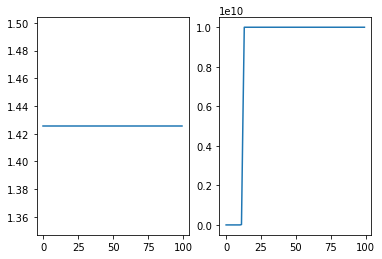

In [146]:
# def iLQR(env, iterations=100):

"""
todo:
- fix cost history
- line search for alpha parameter
- add convergence check
"""

# temp
env = PointMass()
iterations = 100

reg = 1                  # initial regularization
reg_lims = (1e-6, 1e10)  # limtis on regularization
dreg = 2                 # reg is multiplied or divided by dreg
dreg_factor = 1.6        # dreg is multiplied or diveded by dreg_factor


# initial trajectory
actions = [(0,0) for i in range(env.max_steps)]
states, costs, costs_derivs = env.rollout(actions)
state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
V_x  = costs_derivs[-1]['l_x']
V_xx = costs_derivs[-1]['l_xx']
history = dict(cost=[], reg=[])

for i in tqdm(range(iterations)):
    k, K = [], []
    
    # backward pass
    # (computed new control rules k and K)
    for t in range(env.max_steps-1, -1, -1):
        l, f = costs_derivs[t], state_derivs[t]
        
        Q_x  = l['l_x']  + f['f_x'].T @ V_x
        Q_u  = l['l_u']  + f['f_u'].T @ V_x
        Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
        Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
        Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']
        
        # compute Q_uu inverse
        evals, evecs = np.linalg.eig(Q_uu)
        evals[evals<0] = 0.0
        evals += reg
        Q_uu_inv = evecs @ np.diag(1/evals) @ evecs.T
        
        # control law
        k.append(-Q_uu_inv @ Q_u)
        K.append(-Q_uu_inv @ Q_ux)
        
        # update V
        V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
        V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]
    k.reverse()
    K.reverse()
    
    # forward pass
    # (compute new trajectory with new control law)
    states_new, costs_new, actions_new = [], [], []
    states_new.append(env.reset(reset_target=False))
    
    for t in range(env.max_steps):
        action_new = actions[t] + k[t] + K[t] @ (states_new[-1] - states[t])
        actions_new.append(action_new)
        costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
        states_new.append(env.step(actions_new[-1]))
    
    # regularization update
    delta_cost = sum(costs_new) - sum(costs)
    
    if delta_cost>0:  # increase regularization
        dreg = max(dreg_factor, dreg_factor*dreg)
        reg = np.clip(reg*dreg, reg_lims[0], reg_lims[1])
        
    else:             # decrease regularization
        dreg = min(1/dreg_factor, dreg/dreg_factor)
        reg *= dreg * (reg < reg_lims[0])
        
        actions = actions_new
        states = states_new
        costs = costs_new
    
    history['cost'].append(sum(costs))
    history['reg'].append(reg)
    
axes = plt.subplots(1,2)[1];
axes[0].plot(history['cost']);
axes[1].plot(history['reg']);


In [147]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))